# Detailed analysis of NIST Ground dataset (Executable without Solar Data Tools)

This notebook is a detailed version using PVPRO to analyze the NIST dataset, including preprocessing, parameter extraction, and postprocessing.

It can be run without Solar Data Tools.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [1]:
import pandas as pd
from pvlib.pvsystem import retrieve_sam
from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.plotting import plot_results_timeseries, plot_post_processed_results, plot_operating_condition, plot_dc_power
from pvpro.postprocess import PostProcessor

## Load data

In [2]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/nist_ground_array_dataset
dfi = pd.read_pickle('examples/data/nist01_onemin-Ground.pkl')
df_pvpro = dfi[::20] # downsample to 20 min

In [3]:
# Meta information of PV module
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6 # units of A/C
delta_T = 3
technology = 'mono-Si'
module = retrieve_sam('CECmod')['Sharp_NU_U235F2']

## Preprocess data

In [4]:
pre = Preprocessor(voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series,
                   ignore_warning=True
                   )
# If solar data tool is available, change 'use_sdt' to True
df_pvpro = pre.run_basic_preprocess(df_pvpro, use_sdt = False)
df_pvpro['current_irradiance_outliers'], filter_IG_info = pre.find_current_irradiance_outliers(
                                                    df_pvpro, points_per_iteration=1000)
df_pvpro['voltage_temperature_outliers'], filter_VT_info= pre.find_temperature_voltage_outliers(df_pvpro, 
                                                  voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=1000) 

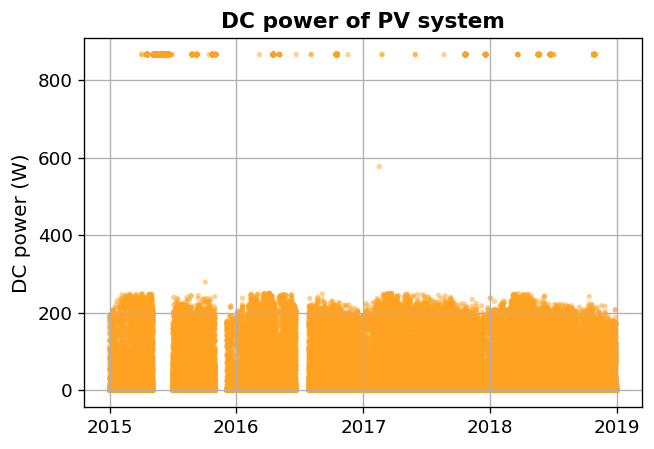

In [5]:
plot_dc_power(df_pvpro)

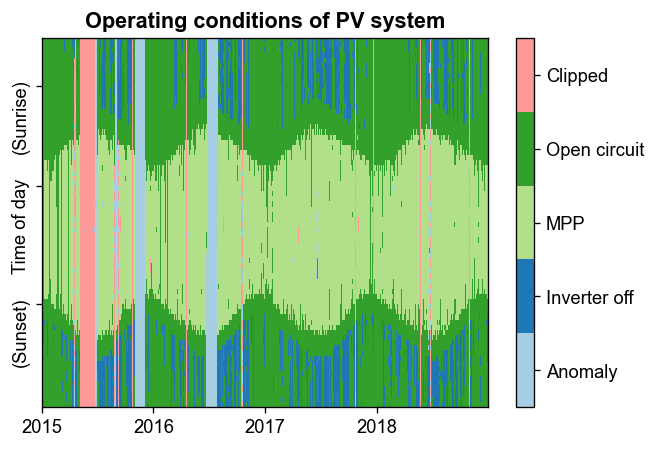

In [6]:
plot_operating_condition(df_pvpro)

## Parameter extraction

In [7]:
pvp = PvProHandler(df=df_pvpro,
                   voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   technology=technology,
                   days_per_run = 14
                  )

# Run pipeline to get the SDM parameters
pfit_raw = pvp.run_pipeline()

100%|██████████| 104/104 [00:04<00:00, 22.78it/s]

Elapsed time: 0.08 min


## Plot degradation trend of parameters

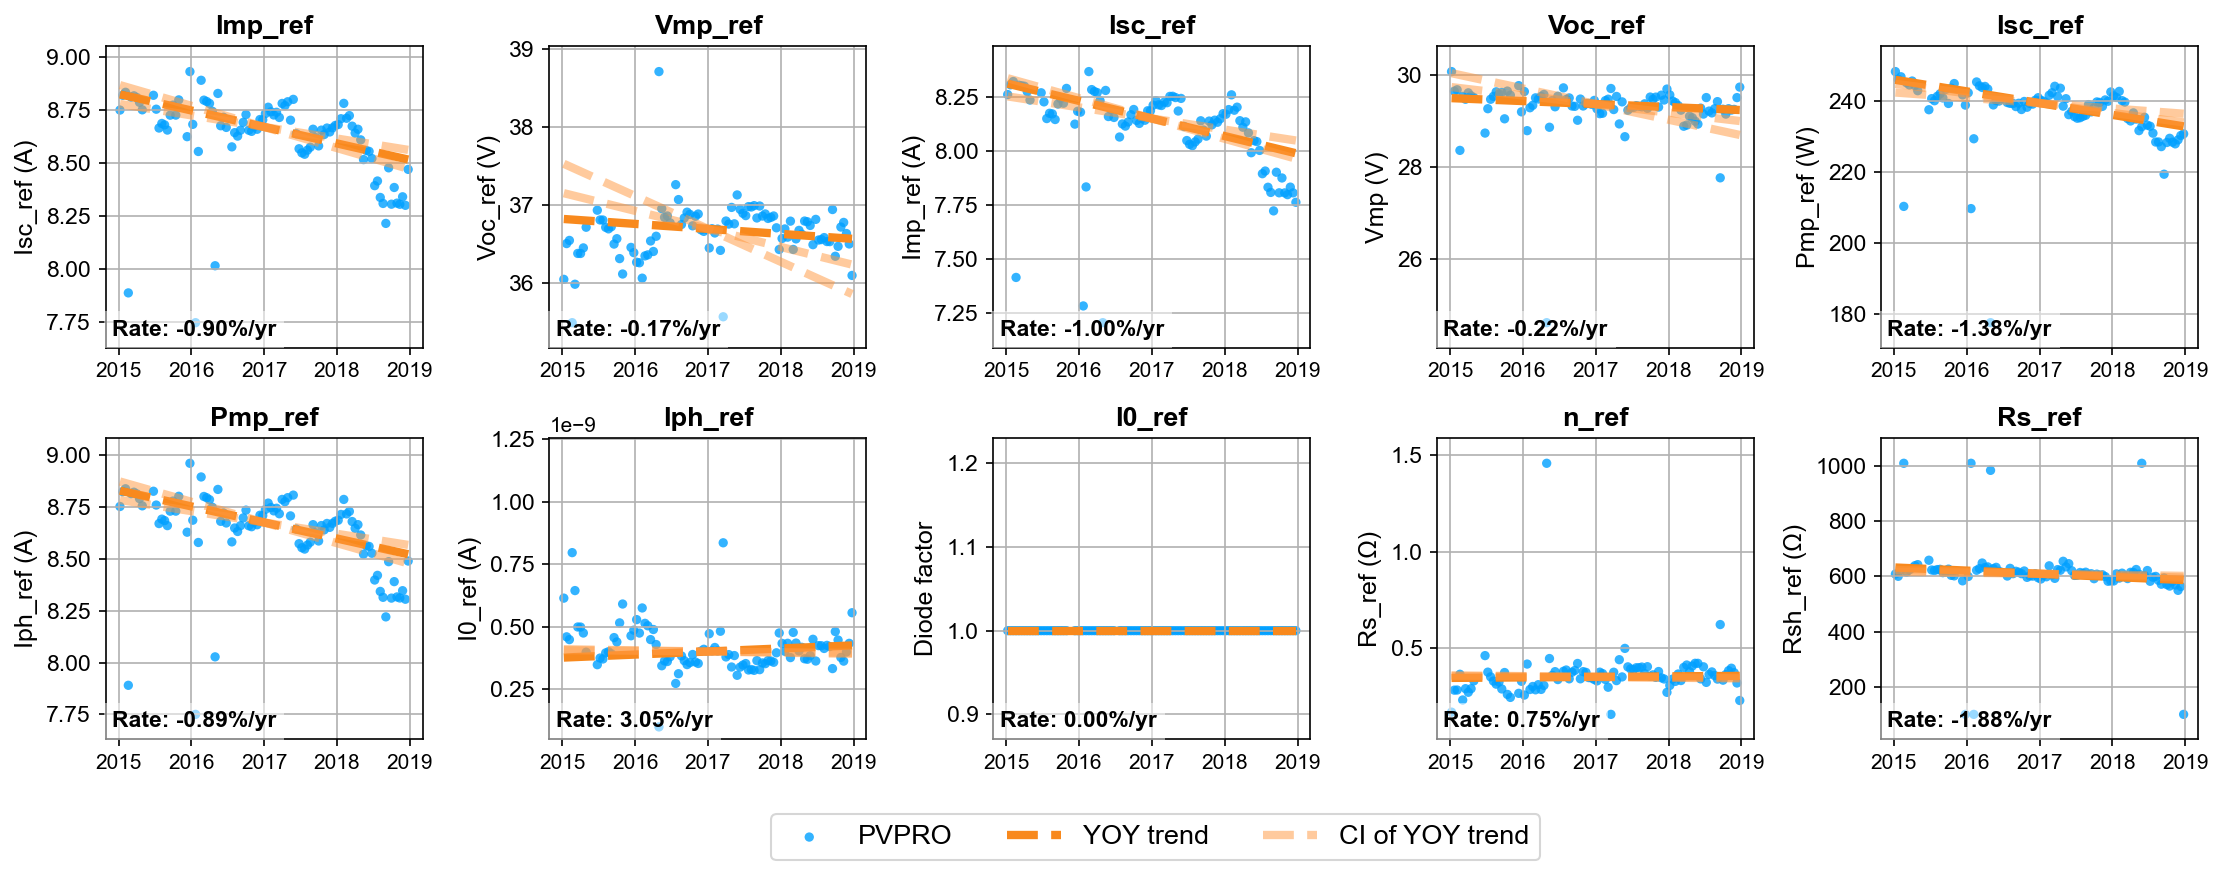

In [8]:
pfit = pfit_raw.copy()

# Remove outliers (optional)
# pfit = pvp.remove_outliers(pfit)

# Calculate year-of-year (YOY) trend
yoy_result = pvp.analyze_yoy(pfit)

# Plot the evolution of extracted parameters
plot_results_timeseries(pfit,
                        yoy_result = yoy_result)

## Post-processing of results

The post-processor formulates a signal decomposition problem to estimate a “clean” trend of the PVPro parameter changes over time, with noise and seasonality removed.

In [9]:
days_per_run = 14
period = 365/days_per_run
options = {'index_col': 0, 'dates': None, 'df_prep': True, 'include': None, 'exclude': None, 'verbose': True, 'bp': False}
post = PostProcessor(pfit, period, **options)
post.analyze_pipline()

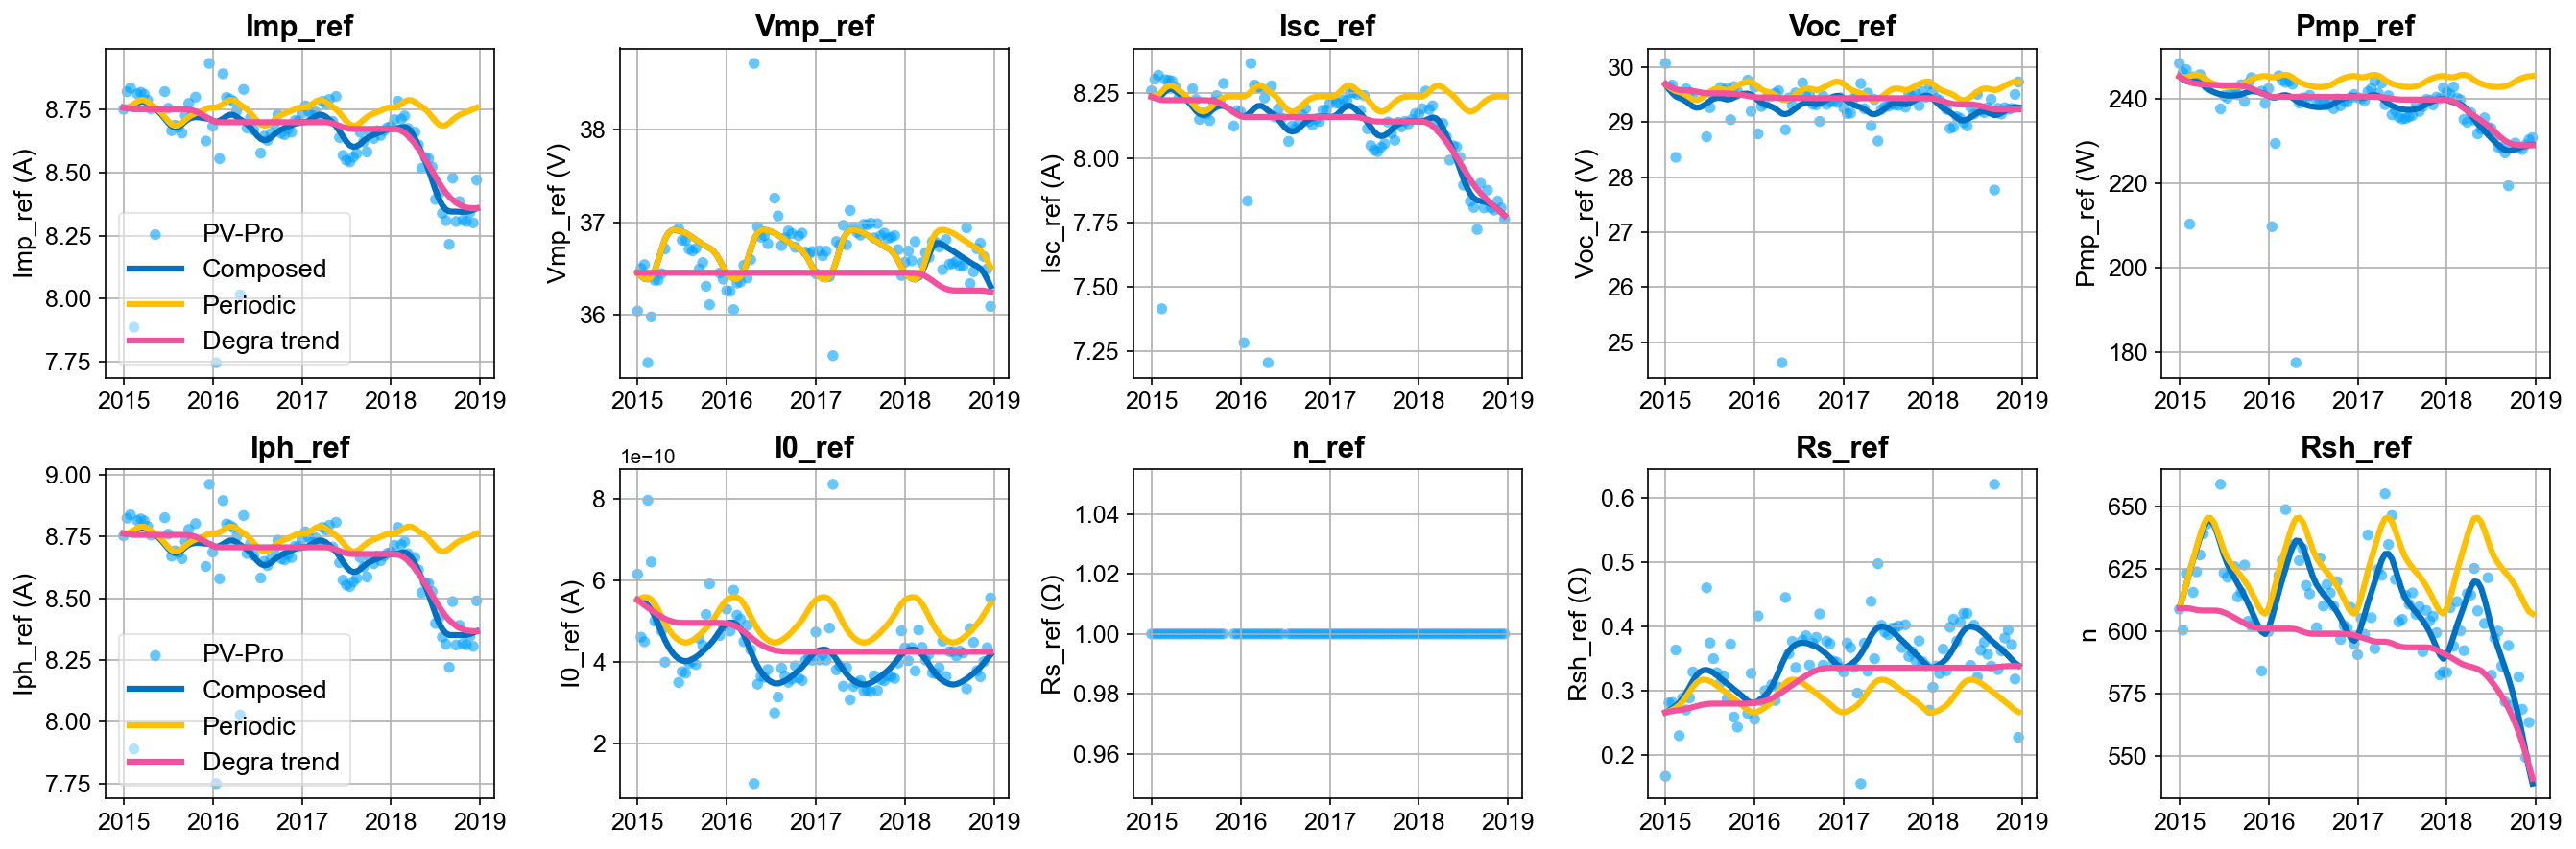

In [10]:
plot_post_processed_results(post)